# Transfer learning with tensorflow
In this notebook, I will implement the concept of transfer learning with different popular models and multiple datasets and analyse the results

### First lets try models on a simple dogs vs cats dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.utils import shuffle

Function to load the data

In [2]:
def get_images(directory):
    Images = []
    Labels = []  # 0 for cat , 1 for dog
    label = 0
    
    for labels in os.listdir(directory): #Main Directory where each class label is present as folder name.
        if labels == 'cats':
            label = 0
        elif labels == 'dogs':
            label = 1

        for image_file in os.listdir(directory+labels): #Extracting the file name of the image from Class Label folder
            
            image = cv2.imread(directory+labels+r'/'+image_file) #Reading the image (OpenCV)
            image = cv2.resize(image,(224,224)) #Resize the image, Some images are different sizes. (Resizing is very Important)
            Images.append(image)
            Labels.append(label)
    
    return shuffle(Images,Labels,random_state=817328462) #Shuffle the dataset you just prepared.

def get_classlabel(class_code):
    labels = {0:'cat', 1:'dog'}
    
    return labels[class_code]

Loading the data

In [3]:
x_train, y_train = get_images('./data/training_set/') #Extract the training images from the folders.
x_train = np.array(x_train) #converting the list of images to numpy array.
y_train = np.array(y_train)
x_val, y_val = get_images('./data/test_set/') #Extract the training images from the folders.
x_val = np.array(x_val) #converting the list of images to numpy array.
y_val = np.array(y_val)

Lets explore that data

In [4]:
print("Shape of x_train:",x_train.shape)
print("Shape of y_train:",y_train.shape)
print("Shape of x_train:",x_val.shape)
print("Shape of y_train:",y_val.shape)

Shape of x_train: (8005, 224, 224, 3)
Shape of y_train: (8005,)
Shape of x_train: (2023, 224, 224, 3)
Shape of y_train: (2023,)


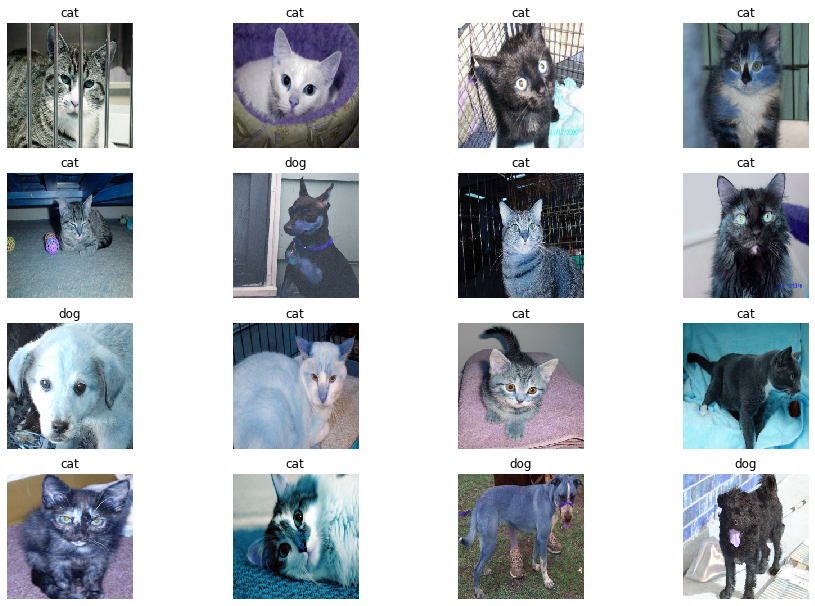

In [5]:
from random import randint
f,ax = plt.subplots(4,4) 
f.subplots_adjust(0,0,2,2)
for i in range(0,4,1):
    for j in range(0,4,1):
        rnd_number = randint(0,len(x_train))
        ax[i,j].imshow(x_train[rnd_number])
        ax[i,j].set_title(get_classlabel(y_train[rnd_number]))
        ax[i,j].axis('off')

### Cool lets procede and build the model applying transfer learning

In [6]:
IMG_SHAPE = (224, 224, 3)

# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

80142336/80134624 [==============================] - 269s 3us/step


In [7]:
base_model.save('VGG19.h5')
base_model.save_weights('VGG19_imagenet_weights.h5')

In [9]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [15]:
base_model.trainable = False

In [11]:
# importing the necessary moduels 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

In [12]:
flatten_layer = Flatten()
dense_layer_1 = Dense(150, activation='relu')
dense_layer_2 = Dense(100, activation='relu')
dropout_layer = Dropout(0.3)
prediction_layer = Dense(2, activation='sigmoid')

In [16]:
model = Sequential([
                    base_model,
                    flatten_layer, 
                    dense_layer_1,
                    dense_layer_2,
                    dropout_layer,
                    prediction_layer])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 150)               3763350   
_________________________________________________________________
dense_1 (Dense)              (None, 100)               15100     
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 202       
Total params: 23,803,036
Trainable params: 3,778,652
Non-trainable params: 20,024,384
__________________________________

In [17]:
len(model.trainable_variables)

6

In [25]:
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [36]:
ACCURACY_THRESHOLD = 0.98
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

callbacks = myCallback()
            
trained = model.fit(x_train,y_train,epochs=50,validation_split=0.30,callbacks = [callbacks])

Train on 5603 samples, validate on 2402 samples
Epoch 1/50
5600/5603 [============================>.] - ETA: 0s - loss: 0.0055 - accuracy: 0.9993
Reached 98.00% accuracy, so stopping training!!
5603/5603 [==============================] - 152s 27ms/sample - loss: 0.0055 - accuracy: 0.9993 - val_loss: 0.2851 - val_accuracy: 0.9738


In [ ]:
model.evaluate(x_val,y_val, verbose=1)

I had trained the model multiple times previously, the wieghts had already been adjusted and we reached 99% accuracy just in one epoch.

Anyway! We were able to achieve ~100 very easily with the help of pre-trained weights!
Now lets try it on a CIFAR-10

## Preparing CIFAR-10 dataset

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [40]:
def unpickle(file):
    """load the cifar-10 data"""

    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_cifar_10_data(data_dir, negatives=False):
    """
    Return train_data, train_filenames, train_labels, test_data, test_filenames, test_labels
    """

    # get the meta_data_dict
    # num_cases_per_batch: 1000
    # label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    # num_vis: :3072

    meta_data_dict = unpickle(data_dir + "/batches.meta")
    cifar_label_names = meta_data_dict[b'label_names']
    cifar_label_names = np.array(cifar_label_names)

    # training data
    cifar_train_data = None
    cifar_train_filenames = []
    cifar_train_labels = []

    # cifar_train_data_dict
    # 'batch_label': 'training batch 5 of 5'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    for i in range(1, 6):
        cifar_train_data_dict = unpickle(data_dir + "/data_batch_{}".format(i))
        if i == 1:
            cifar_train_data = cifar_train_data_dict[b'data']
        else:
            cifar_train_data = np.vstack((cifar_train_data, cifar_train_data_dict[b'data']))
        cifar_train_filenames += cifar_train_data_dict[b'filenames']
        cifar_train_labels += cifar_train_data_dict[b'labels']

    cifar_train_data = cifar_train_data.reshape((len(cifar_train_data), 3, 32, 32))
    if negatives:
        cifar_train_data = cifar_train_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_train_data = np.rollaxis(cifar_train_data, 1, 4)
    cifar_train_filenames = np.array(cifar_train_filenames)
    cifar_train_labels = np.array(cifar_train_labels)

    # test data
    # cifar_test_data_dict
    # 'batch_label': 'testing batch 1 of 1'
    # 'data': ndarray
    # 'filenames': list
    # 'labels': list

    cifar_test_data_dict = unpickle(data_dir + "/test_batch")
    cifar_test_data = cifar_test_data_dict[b'data']
    cifar_test_filenames = cifar_test_data_dict[b'filenames']
    cifar_test_labels = cifar_test_data_dict[b'labels']

    cifar_test_data = cifar_test_data.reshape((len(cifar_test_data), 3, 32, 32))
    if negatives:
        cifar_test_data = cifar_test_data.transpose(0, 2, 3, 1).astype(np.float32)
    else:
        cifar_test_data = np.rollaxis(cifar_test_data, 1, 4)
    cifar_test_filenames = np.array(cifar_test_filenames)
    cifar_test_labels = np.array(cifar_test_labels)

    return cifar_train_data, cifar_train_filenames, cifar_train_labels, \
        cifar_test_data, cifar_test_filenames, cifar_test_labels, cifar_label_names

In [41]:
cifar_10_dir = 'data/cifar-10-batches-py'

train_data, train_filenames, train_labels, test_data, test_filenames, test_labels, label_names = load_cifar_10_data(cifar_10_dir)

print("Train data: ", train_data.shape)
print("Train filenames: ", train_filenames.shape)
print("Train labels: ", train_labels.shape)
print("Test data: ", test_data.shape)
print("Test filenames: ", test_filenames.shape)
print("Test labels: ", test_labels.shape)
print("Label names: ", label_names.shape)

Train data:  (50000, 32, 32, 3)
Train filenames:  (50000,)
Train labels:  (50000,)
Test data:  (10000, 32, 32, 3)
Test filenames:  (10000,)
Test labels:  (10000,)
Label names:  (10,)


## Now lets prepare the model

In [60]:
base_model = tf.keras.models.load_model('VGG19.h5')
base_model.load_weights('VGG19_imagenet_weights.h5')

In [61]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda

original_dim = (32, 32, 3)
target_size = (224, 224)
base_model.trainable = False

input_layer = Input(original_dim)
lambda_layer = Lambda(lambda image: tf.image.resize(image, target_size))
flatten_layer = Flatten()
dense_layer_1 = Dense(150, activation='relu')
dense_layer_2 = Dense(100, activation='relu')
dropout_layer = Dropout(0.3)
prediction_layer = Dense(10, activation='softmax')


In [62]:
model = Sequential([
                    input_layer,
                    lambda_layer,   
                    base_model,
                    flatten_layer, 
                    dense_layer_1,
                    dense_layer_2,
                    dropout_layer,
                    prediction_layer])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 150)               3763350   
_________________________________________________________________
dense_19 (Dense)             (None, 100)               15100     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 10)               

## Model is ready to be trained ! 

In [63]:
import tensorflow.keras.optimizers as Optimizer
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer=Optimizer.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [65]:
ACCURACY_THRESHOLD = 0.98
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

early = EarlyStopping(monitor='loss', patience=3)
callbacks = myCallback()
            
trained = model.fit(train_data,train_labels,epochs=50,validation_split=0.30,callbacks = [callbacks, early])

Train on 35000 samples, validate on 15000 samples
Epoch 1/50
35000/35000 [==============================] - 986s 28ms/sample - loss: 0.5444 - accuracy: 0.8278 - val_loss: 0.6354 - val_accuracy: 0.8035
Epoch 2/50
35000/35000 [==============================] - 988s 28ms/sample - loss: 0.3302 - accuracy: 0.8918 - val_loss: 0.6220 - val_accuracy: 0.8237
Epoch 3/50
35000/35000 [==============================] - 988s 28ms/sample - loss: 0.2194 - accuracy: 0.9277 - val_loss: 0.6483 - val_accuracy: 0.8280
Epoch 4/50
35000/35000 [==============================] - 988s 28ms/sample - loss: 0.1560 - accuracy: 0.9486 - val_loss: 0.6967 - val_accuracy: 0.8277
Epoch 5/50
35000/35000 [==============================] - 988s 28ms/sample - loss: 0.1144 - accuracy: 0.9627 - val_loss: 0.7501 - val_accuracy: 0.8325
Epoch 6/50
35000/35000 [==============================] - 982s 28ms/sample - loss: 0.0926 - accuracy: 0.9710 - val_loss: 0.8128 - val_accuracy: 0.8254
Epoch 7/50
35000/35000 [====================

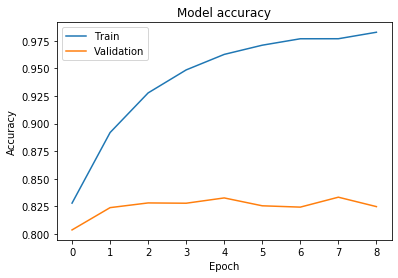

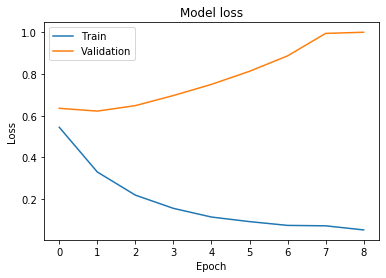

In [70]:
plt.plot(trained.history['accuracy'])
plt.plot(trained.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(trained.history['loss'])
plt.plot(trained.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### 98 % on the training set and 84 on the validation set, the model needs to generalize better. The choice here would be to implement regularization so we dont overfit to the training data

In [71]:
model.save('VGG19_trainedonCIFAR10.h5')
model.save_weights('VGG19_trainedonCIFAR10_weights.h5')

In [73]:
model.evaluate(test_data,test_labels, verbose=1)

10000/10000 [==============================] - 190s 19ms/sample - loss: 1.0679 - accuracy: 0.8220


[1.0679033056378364, 0.822]

### 82% on the training data . . not bad but we can tune it better. Lets look at some of the predictions

In [78]:
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

In [80]:
# label_names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
decode_dict = {
    0:'airplane',
    1:'automobile',
    2:'bird',
    3:'cat',
    4:'deer',
    5:'dog',
    6:'frog',
    7:'horse',
    8:'ship',
    9:'truck'
}

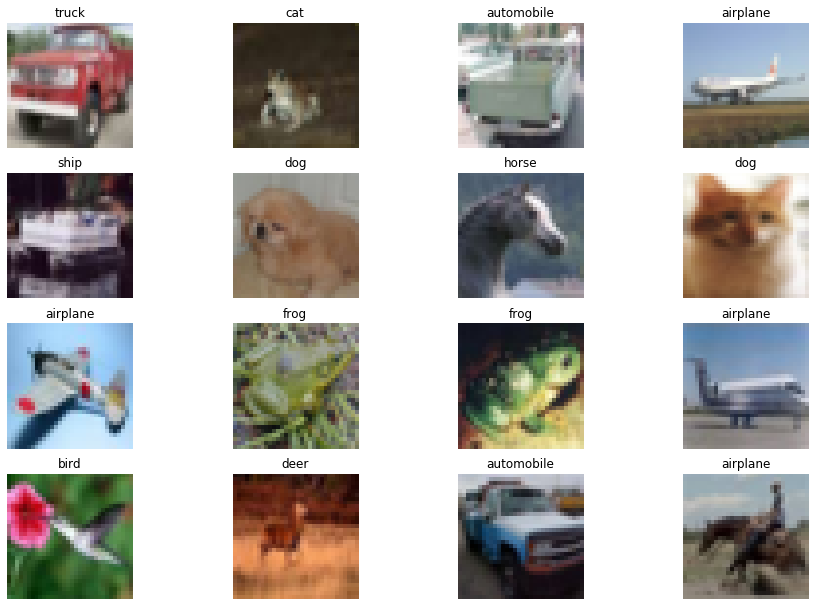

In [88]:
from random import randint
f,ax = plt.subplots(4,4) 
f.subplots_adjust(0,0,2,2)
for i in range(0,4,1):
    for j in range(0,4,1):
        idx = randint(0,len(test_data))
        img = test_data[idx]
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        ax[i,j].imshow(test_data[idx])
        ax[i,j].set_title(decode_dict[np.argmax(model.predict(x))])
        ax[i,j].axis('off')

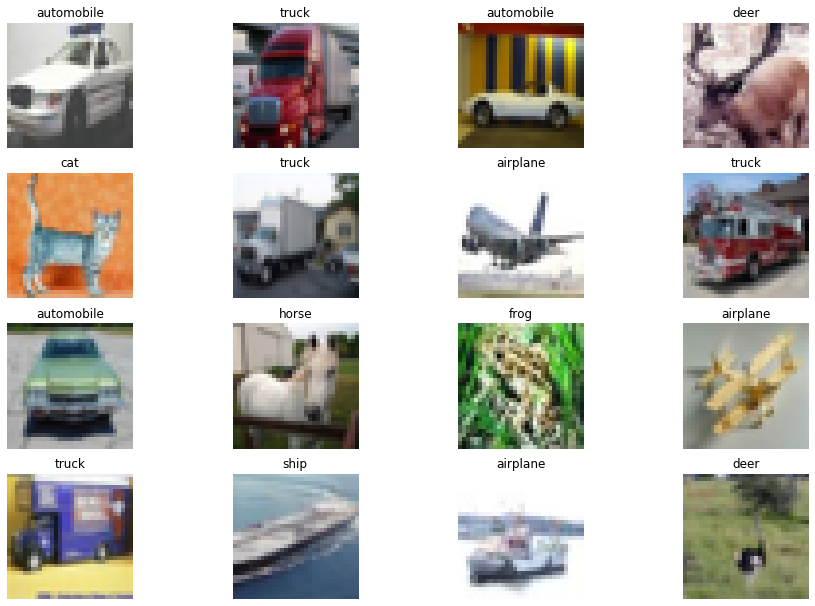

In [89]:
from random import randint
f,ax = plt.subplots(4,4) 
f.subplots_adjust(0,0,2,2)
for i in range(0,4,1):
    for j in range(0,4,1):
        idx = randint(0,len(test_data))
        img = test_data[idx]
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        ax[i,j].imshow(test_data[idx])
        ax[i,j].set_title(decode_dict[np.argmax(model.predict(x))])
        ax[i,j].axis('off')

The pictures are only 32x32, but still the trained model does really well on predicting what the data is!

You can clearly see where the model makes mistakes, some of ones seen above are a ostrich being labelled as a deer or a close up  of a cat being labelled as a dog.

---
From this exercise, you can really understand the importance of transfer learning. 
Lack out data does really affects system performance as seen in the other two noteboooks, however with pretrained weights the model becomes very accurate in detecting and classifing images. 

With more regularization we can decrease the variance and make the model perform better in the testing set.